In [1]:
import json
import numpy as np

# 変な岩の頻度を見てみる
def frequent_pos(pos):
    with_hash = [(hash((x,y)), x, y) for x,y in pos]
    with_hash, count = np.unique(with_hash, return_counts=True, axis=0)
    #with_count = np.concatenate((with_hash, np.array([count]).T), axis=1)
    sorted = with_hash[np.argsort(count)][::-1]
    return sorted[:,1:], np.sort(count)[::-1]

# json から読み込み
js = json.load(open('../logs/rocks.json'))
_poss = np.array([ x['pos'] for x in js ])
_rocks = np.array([ x['rock'] if x['rock'] is not None else (None, None) for x in js  ]) # null 対策
_yaws = np.array([x['yaw'] for x in js ])
_dist = np.array([x['dist'] if x['dist'] is not None else float('inf') for x in js ])
_angle = np.array([x['angle'] if x['angle'] is not None else float('inf') for x in js ])

norm_pitch = np.array([x['norm_pitch'] for x in js ])
#norm_pitch_abs = np.abs(norm_pitch)
norm_roll = np.array([x['norm_roll'] for x in js ])
#norm_roll_abs = np.abs(norm_roll)


# Initialize filter
dist_filter = np.ones_like(norm_pitch) == 1
angle_filter = np.copy(dist_filter)
pitch_filter = np.copy(dist_filter)
roll_filter = np.copy(dist_filter)


# rock と pos との角度によるフィルタ
def rock_angle_filter(angles, range_angle=np.pi/4):
    angles_abs = np.abs(np.array([a if a <= np.pi else a - 2*np.pi for a in angles]))
    return (angles_abs > np.pi/2 - range_angle) * (angles_abs < np.pi/2 + range_angle)

# rock <-> pos 距離によるフィルタ
def rock_distance_filter(dist, threshold = 5.0):
    return dist < threshold

# pitch や roll によるフィルタ処理
# etc.
#   thre_pitch = (-0.05, 0.001)
#   thre_roll = (-0.05, 0.05)
def pitch_roll_filter(norm_pitch, norm_roll, thre_pitch = (-0.1, 0.1), thre_roll = (-0.9, 0.9)):
    pitch_filter = (thre_pitch[0] <= norm_pitch) * (norm_pitch <= thre_pitch[1])
    roll_filter = (thre_roll[0] <= norm_roll) * (norm_roll <= thre_roll[1])
    return pitch_filter, roll_filter

#angle_filter = rock_angle_filter(_angle)  # 目標点との角度フィルタ
dist_filter = rock_distance_filter(_dist)  # 目標点との距離フィルタ
pitch_filter, roll_filter = pitch_roll_filter(norm_pitch, norm_roll) # 姿勢でのフィルタ

total_filter = pitch_filter * roll_filter * dist_filter * angle_filter

poss = np.copy(_poss[total_filter])
rocks = np.copy(_rocks[total_filter])
yaws = np.copy(_yaws[total_filter])

# poss = np.copy(_poss)
# rocks = np.copy(_rocks)
# yaws = np.copy(_yaws)

poss_xy = (poss[:,0], poss[:,1])
rocks_xy = (rocks[:,0], rocks[:,1])
_poss_xy = (_poss[:,0], _poss[:,1])
_rocks_xy = (_rocks[:,0], _rocks[:,1])

last_poss = poss[-1]
last_rocks = rocks[-1]
last_yaw = yaws[-1]

print('len:', len(poss), len(rocks), len(yaws), len(_poss_xy[0]), len(_rocks_xy[0]), len(_dist), len(_angle))
print('(min,max) pitch, roll:', \
      (np.min(norm_pitch), np.max(norm_pitch)),\
      (np.min(norm_roll), np.max(norm_roll)))

len: 254 254 254 19700 19700 19700 19700
(min,max) pitch, roll: (-30.750800000000027, 20.529299999999999) (-37.741499999999974, 16.1068)


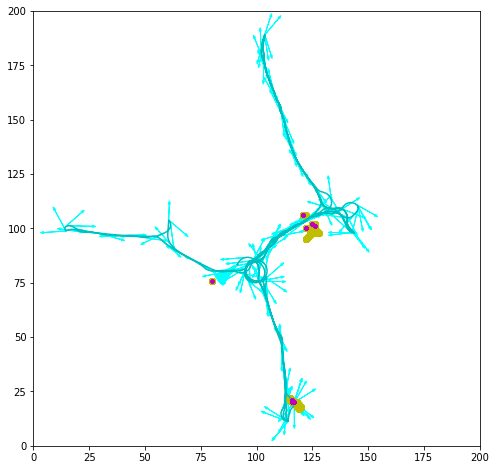

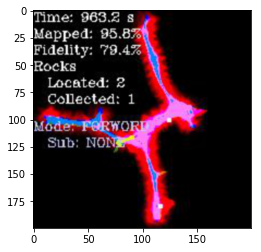

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 各工程ごとに表示
fig = plt.figure(figsize=(8,8)) # 表示領域の設定
#m = 70
#plt.ylim(0+m*1.2, 200-m)
#plt.xlim(0+m*1.2, 200-m)
# plt.ylim(90, 130)
# plt.xlim(90, 130)
plt.ylim(0, 200)
plt.xlim(0, 200)


# yaw を矢印で表示
arrow_length = 10
yaw_angle = _yaws / 180 * np.pi
x_arrows = arrow_length * np.cos(yaw_angle)
y_arrows = arrow_length * np.sin(yaw_angle)
xs = _poss_xy[0]
ys = _poss_xy[1]

for i in range(len(yaw_angle)):
    if i % 100 == 0:
        plt.arrow(xs[i], ys[i], x_arrows[i], y_arrows[i], color='cyan', head_width=1)

# Plot latest points
# rover と rock の位置を plot
plt.plot(_rocks_xy[0], _rocks_xy[1], 'yo')
plt.plot(_poss_xy[0], _poss_xy[1], 'c-')
plt.plot(rocks_xy[0], rocks_xy[1], 'm.')
plt.show()

plt.imshow(mpimg.imread('../misc/worldmap04.jpg'), aspect='equal', interpolation='bicubic')  # 古いかも
plt.show()

(min,max) pitch, roll: (-30.750800000000027, 20.529299999999999) (-37.741499999999974, 16.1068)
(min,max) filtered pitch, roll: (-0.099899999999990996, 0.0998) (-0.89999999999997726, 0.89990000000000003)
len: 19700 19700 5460 5460


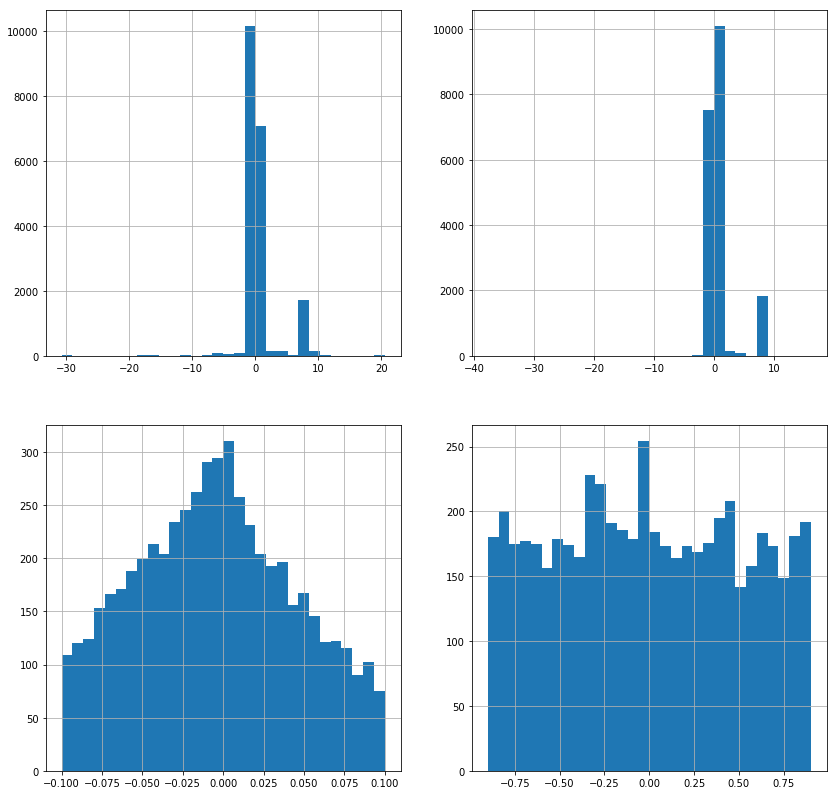

In [3]:
# roll, pitch のヒストグラフ
# ノイズを見たい, 省きたい

# 設定値
bins=30

# ノイズぽいのを間引く
#_norm_pitch = np.copy(norm_pitch)
#_norm_roll = np.copy(norm_roll)
#print((norm_roll < 2.0) * (norm_roll > -2.0))

_thre_pitch = 0.1
pitch_filter = (-_thre_pitch < norm_pitch) * (norm_pitch < _thre_pitch)
_thre_roll = 0.9
roll_filter = (-_thre_roll < norm_roll) * (norm_roll < _thre_roll)

_norm_pitch = np.copy(norm_pitch[pitch_filter * roll_filter])
_norm_roll = np.copy(norm_roll[pitch_filter * roll_filter])


print('(min,max) pitch, roll:', \
      (np.min(norm_pitch), np.max(norm_pitch)),\
      (np.min(norm_roll), np.max(norm_roll)))
print('(min,max) filtered pitch, roll:', \
      (np.min(_norm_pitch), np.max(_norm_pitch)),\
      (np.min(_norm_roll), np.max(_norm_roll)))
print('len:', len(norm_pitch), len(norm_roll), len(_norm_pitch), len(_norm_roll))

fig = plt.figure(figsize=(14,14))
# 上下
plt.subplot(2,2, 1)
plt.hist(norm_pitch, bins=bins,log=False)
plt.grid(True)

plt.subplot(2,2, 3)
plt.hist(_norm_pitch, bins=bins,log=False)
plt.grid(True)


# 横揺れ
plt.subplot(2,2, 2)
plt.hist(norm_roll, bins=bins,log=False)
plt.grid(True)


plt.subplot(2,2, 4)
plt.hist(_norm_roll, bins=bins,log=False)
plt.grid(True)
plt.show()

-----

## Sandbox


In [4]:
# from extra_functions import perspect_transform_, color_thresh, rover_coords, get_source_and_destination
# import typing as t

# # 極座標に変換する
# # x,y -> 距離, 角度
# def to_polar_coords(xpix, ypix):
#     dists = np.sqrt(xpix**2 + ypix**2)
#     angles = np.arctan2(ypix, xpix)
#     return dists, angles

# Vector = t.Tuple
# def normalize_vector(a: Vector) -> Vector: 
#     """Get unit vector"""
#     return a / np.linalg.norm(a)

# def angle_between(a: Vector, b: Vector) -> float:
#     """Get angle of vector A and b"""
#     unit_a = normalize_vector(a)
#     unit_b = normalize_vector(b)
#     return np.arccos(np.clip(np.dot(unit_a, unit_b), -1.0, 1.0))


# # 同一座標の頻度によるフィルタ
# __rocks, _rock_count = frequent_pos(_rocks)
# print()

# poss = np.copy(_poss)
# rocks = np.copy(__rocks[_rock_count > 500])
# yaws = np.copy(_yaws)



# # 最後の方の rover と rock の位置を plot
# tail = len(rocks_xy[0]) // 10
# plt.plot(rocks_xy[0][-tail:], rocks_xy[1][-tail:], 'g.')
# tail = len(_poss_xy[0]) // 20
# plt.plot(_poss_xy[0][-tail:], _poss_xy[1][-tail:], 'b-')



# # # 角度を矢印として重ねて表示
# dist, angle = find_nearest_rock(last_rocks, last_poss)
# arrow_length = dist / 2
# x_arrow = arrow_length * np.cos(angle)
# y_arrow = arrow_length * np.sin(angle)
# plt.arrow(last_poss[0], last_poss[1], x_arrow, y_arrow, color='red', head_width=1)

# # Plot last points
# plt.plot(last_rocks[0], last_rocks[1], 'ro')
# plt.plot(last_poss[0], last_poss[1], 'b*')


# # 角度計算の処理
# # 0..360 -> -180..180
# yaws180 = np.array([yaw if yaw <= 180 else yaw - 360 for yaw in yaws])
# #print('yaws:', yaws)
# #print('yaws180:'yaws180)

# deg = angle*180/np.pi
# # Humm... (inefficient delta)
# delta_angle = deg - yaws180[-1]

# da = delta_angle/180.0*np.pi
# arrow_length = dist
# x_arrow = arrow_length * np.cos(da)
# y_arrow = arrow_length * np.sin(da)
# plt.arrow(last_poss[0], last_poss[1], x_arrow, y_arrow, color='green', head_width=0.2)
# print({'delta_angle': delta_angle, 'yaw180': yaws180[-1], 'deg': deg})



# [(dist, angle)]
# nearests = np.array([ find_nearest_rock(r, p) for r, p in zip(rocks, poss) ])
# near_dists = nearests[:,0] / 4
# near_angles = nearests[:,1]

# near_degs = near_angles*180/np.pi
# near_delta_degs = near_degs - yaws180

# near_delta_angles = near_delta_degs*180/np.pi
# near_x_arrows = near_dists * np.cos(near_delta_angles)
# near_y_arrows = near_dists * np.sin(near_delta_angles)

# for i in range(len(near_delta_angles)):
#     if i % 10 == 0:
#         plt.arrow(xs[i], ys[i], near_x_arrows[i], near_y_arrows[i], color='orange', head_width=0.4)

#angles = [ ]
#plt.plot(rocks_xy[0], rocks_xy[1], 'g.')
#plt.plot(poss_xy[0], poss_xy[1], 'c-')


# 岩の角度を計算
# #xs, x_arrows, ys, y_arrows , (yaws) # rover
# #rocks_xy[0], rocks_xy[1]  # rock
# v_yaws = np.stack((x_arrows, y_arrows), axis=1)  # rover の進行方向ベクトル like np.array(list(zip(x_arrows, y_arrows)))
# #print('x_arrows, y_arrows:', x_arrows, y_arrows)
# #print('v_yaws:', v_yaws)

# # roverから見た岩のベクトル
# v_rocks = np.stack((rocks_xy[0]-xs, rocks_xy[1]-ys), axis=1)
# #print('v_rocks:', v_rocks)

# rock_angles = np.array([angle_between(v1,v2) for v1, v2 in zip(v_yaws, v_rocks)])
# print('rock_angles:', rock_angles)
# print('  :', {'min': np.min(rock_angles), 'max': np.max(rock_angles)})
# rock_degs = rock_angles*180/np.pi
# print('rock_degs:', rock_degs)
# print('  :', {'min': np.min(rock_degs), 'max': np.max(rock_degs)})

##print(rock_degs[0], rock_degs[-1])
#print(v_yaws)

[ 0.  1.] [ 0.70710678  0.70710678] [ 1.  0.]
[  1.57079633e+00   2.10734243e-08   3.14159265e+00   3.14159265e+00
   1.47112767e+00]
[ 90   0 180 180  84]


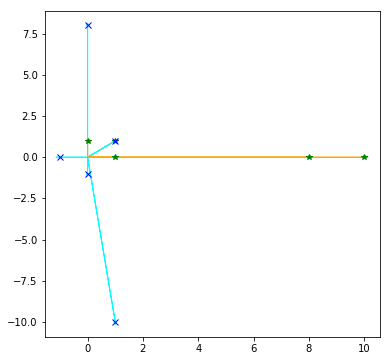

In [5]:
import typing as t

def normalize_vector(a: t.Tuple) -> t.Tuple:
    """Get unit vector"""
    return a / np.linalg.norm(a)

def angle_between(a: t.Tuple, b: t.Tuple) -> float:
    """Get angle of vector A and b"""
    unit_a = normalize_vector(a)
    unit_b = normalize_vector(b)
    return np.arccos(np.dot(unit_a, unit_b))
    
vector_pairs = np.array(
    [[[8,0],[0,8]], [[1,1],[1,1]], [[0,1],[0,-1]], [[1,0],[-1,0]], [[10,0],[1,-10]]])
#    [[[8,0],[0,8]], [[1,1],[1,1]]])

angles = np.array([ angle_between(a,b) for a,b in vector_pairs])
degrees = angles * 180.0 / np.pi

print(normalize_vector([0,10]), normalize_vector([10,10]),  normalize_vector([10,0]))
print(angles)
print(degrees.astype(int))

fig = plt.figure(figsize=(6,6)) # 表示領域の設定

for i in range(len(vector_pairs)):
    a,b = vector_pairs[i]
    plt.arrow(0, 0, a[0], a[1], color='orange', head_width=0.1)
    plt.arrow(0, 0, b[0], b[1], color='cyan', head_width=0.1)

#     # 角度を矢印で表示
#     ang = angles[i]
#     length = 1.0
#     x = length * np.cos(ang)
#     y = length * np.sin(ang)
#     plt.arrow(a[0], a[1], x, y, color='red', head_width=0.1)
    

for a,b in vector_pairs:
    plt.plot(a[0], a[1], 'g*')
    plt.plot(b[0], b[1], 'bx')

In [6]:
[ (r,p) for r, p in zip(rocks, poss) ]

[(array([80, 76], dtype=object), array([ 81.1064,  80.773 ])),
 (array([80, 76], dtype=object), array([ 80.9186,  80.8444])),
 (array([80, 76], dtype=object), array([ 80.8059,  80.8886])),
 (array([80, 76], dtype=object), array([ 80.8059,  80.8886])),
 (array([80, 76], dtype=object), array([ 80.731 ,  80.9183])),
 (array([80, 76], dtype=object), array([ 80.6565,  80.9481])),
 (array([125, 102], dtype=object), array([ 125.9418,  105.4986])),
 (array([125, 102], dtype=object), array([ 125.9418,  105.4986])),
 (array([125, 102], dtype=object), array([ 125.8249,  105.4775])),
 (array([125, 102], dtype=object), array([ 125.6307,  105.4429])),
 (array([125, 102], dtype=object), array([ 125.6307,  105.4429])),
 (array([125, 102], dtype=object), array([ 125.1617,  105.3451])),
 (array([125, 102], dtype=object), array([ 124.9656,  105.2973])),
 (array([125, 102], dtype=object), array([ 124.9656,  105.2973])),
 (array([125, 102], dtype=object), array([ 124.8501,  105.2637])),
 (array([125, 102],